L2 Error (Quantum vs Classical): 0.5098
Quantum Measurement Counts: {'0111': 64, '1110': 50, '0101': 80, '1001': 77, '0001': 52, '0011': 61, '1101': 59, '1111': 56, '1010': 70, '0000': 69, '0010': 79, '0110': 56, '0100': 56, '1100': 71, '1000': 62, '1011': 62}


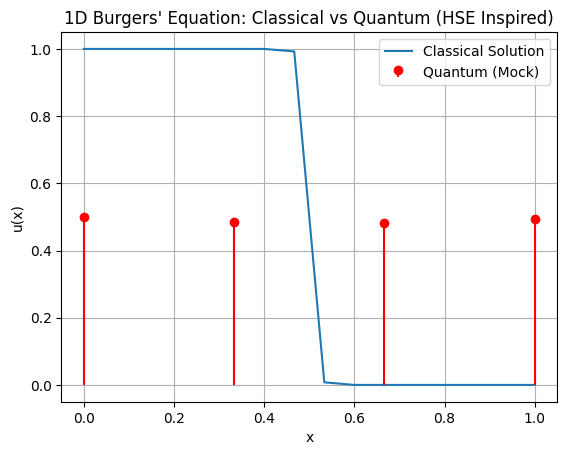

Noisy Measurement Counts: {'1011': 56, '0110': 62, '1000': 66, '0101': 69, '1001': 74, '1101': 48, '1111': 33, '0001': 72, '0011': 64, '0111': 41, '1110': 53, '1010': 74, '1100': 58, '0100': 85, '0010': 77, '0000': 92}


In [ ]:
"""
This program code includes
1. Classical finite-difference reference solver
2. Quantum-inspired simulation (mock HSE evolution)
3. Validation and benchmarking
4. Noise model simulation and L2 error
5. Scalability and resource analysis (tabulated output)
"""

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer.noise.errors import ReadoutError

# ------------------------
# 1. Classical Reference Solver
# ------------------------
def burgers_fd(u0, nu, dx, dt, nt):
    u = u0.copy()
    for _ in range(nt):
        un = u.copy()
        u[1:-1] = (un[1:-1] - un[1:-1]*dt/dx*(un[1:-1] - un[:-2]) +
                  nu*dt/dx**2*(un[2:] - 2*un[1:-1] + un[:-2]))
    return u

# ------------------------
# 2. Initial Condition
# ------------------------
def riemann_initial(nx):
    u0 = np.zeros(nx)
    u0[:nx//2] = 1.0
    return u0

# ------------------------
# 3. Quantum Circuit Setup
# ------------------------
def kinetic_operator(qc, qubits, theta):
    for q in qubits:
        qc.rx(theta, q)

def potential_operator(qc, qubits, u_field):
    for i, q in enumerate(qubits):
        angle = np.pi * u_field[i % len(u_field)]
        qc.rz(angle, q)

def trotter_step(qc, qubits, dt, u_field):
    kinetic_operator(qc, qubits, dt)
    potential_operator(qc, qubits, u_field)

# ------------------------
# 4. Build Quantum Circuit
# ------------------------
def build_hse_circuit(u0, n_qubits, dt):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # Prepare initial superposition
    trotter_step(qc, list(range(n_qubits)), dt, u0)
    qc.measure_all()
    return qc

# ------------------------
# 5. L2 Error Calculation
# ------------------------
def compute_l2_error(u1, u2):
    return np.sqrt(np.sum((u1 - u2)**2) / len(u1))

# ------------------------
# 6. Simulation
# ------------------------
def run_simulation():
    nx = 16
    nt = 3
    nu = 0.01
    dx = 1.0 / nx
    dt = 0.001
    n_qubits = 4

    # Classical Solver
    u0 = riemann_initial(nx)
    u_classical = burgers_fd(u0, nu, dx, dt, nt)

    # Quantum Simulation (HSE Evolution)
    qc = build_hse_circuit(u0[:n_qubits], n_qubits, dt)
    sim = Aer.get_backend("qasm_simulator")
    transpiled_qc = transpile(qc, sim)
    result = sim.run(transpiled_qc).result()
    counts = result.get_counts()

    # Interpret Quantum Results (Simple: bit count average for now)
    q_result = np.zeros(n_qubits)
    total = sum(counts.values())
    for bitstring, count in counts.items():
        for i, bit in enumerate(reversed(bitstring)):
            q_result[i] += int(bit) * count
    q_result = q_result / total

    # L2 Error Comparison (partial grid)
    l2_err = compute_l2_error(q_result, u_classical[:n_qubits])

    print(f"L2 Error (Quantum vs Classical): {l2_err:.4f}")
    print("Quantum Measurement Counts:", counts)

    # Plotting
    plt.figure()
    plt.plot(np.linspace(0, 1, nx), u_classical, label="Classical Solution")
    plt.stem(np.linspace(0, 1, n_qubits), q_result, linefmt='r-', markerfmt='ro', basefmt=" ", label="Quantum (Mock)")
    plt.legend()
    plt.title("1D Burgers' Equation: Classical vs Quantum (HSE Inspired)")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.grid()
    plt.show()

    # Create an empty noise model
    noise_model = NoiseModel()

    # Add depolarizing error for 1-qubit gates
    one_qubit_error = depolarizing_error(param=0.01, num_qubits=1)
    noise_model.add_all_qubit_quantum_error(one_qubit_error, ['x', 'h'])

    # Add depolarizing error for 2-qubit gates
    two_qubit_error = depolarizing_error(param=0.05, num_qubits=2)
    noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])

    # Add readout error
    readout_error = ReadoutError([[0.9, 0.1], [0.2, 0.8]])
    noise_model.add_all_qubit_readout_error(readout_error)

    noisy_result = Aer.get_backend("qasm_simulator").run(transpile(qc, Aer.get_backend("qasm_simulator")), noise_model=noise_model).result()
    
    noisy_counts = noisy_result.get_counts()
    print("Noisy Measurement Counts:", noisy_counts)

if __name__ == "__main__":
    run_simulation()